<a href="https://colab.research.google.com/github/JialinLiOSU/ML-Final-Project/blob/master/Copy_of_Fine_tuning01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -q tensorflow_hub
!pip install pydot graphviz
!pip install pydot3 pydot-ng

  Stored in directory: /root/.cache/pip/wheels/1a/31/21/e66efd6b46380648e70c81de5544952acb3063b806cdd6a417
Successfully built pydot3


In [0]:
from IPython.display import SVG
from keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import model_to_dot
inception_model = InceptionV3(weights='imagenet', include_top=False)
SVG(model_to_dot(inception_model).create(prog='dot', format='svg'))

In [0]:
# check the layers by name
for i,layer in enumerate(inception_model.layers):
    print(i,layer.name)


In [0]:
import random
import cv2
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD
import numpy as np

# read data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# limit the amount of the data
# train data
ind_train = random.sample(list(range(x_train.shape[0])), 2000)
x_train = x_train[ind_train]
y_train = y_train[ind_train]

# test data
ind_test = random.sample(list(range(x_test.shape[0])), 2000)
x_test = x_test[ind_test]
y_test = y_test[ind_test]

def resize_data(data):
    data_upscaled = np.zeros((data.shape[0], 140, 140, 3))
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(140, 140), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img

    return data_upscaled

# resize train and  test data
x_train_resized = resize_data(x_train)
x_test_resized = resize_data(x_test)

# make explained variable hot-encoded
y_train_hot_encoded = to_categorical(y_train)
y_test_hot_encoded = to_categorical(y_test)

In [0]:
inc_model = InceptionV3(weights='imagenet', include_top=False)

# get layers and add average pooling layer
x = inc_model.output
x = GlobalAveragePooling2D()(x)

# add fully-connected layer
x = Dense(512, activation='relu')(x)

# add output layer
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inc_model.input, outputs=predictions)

# freeze pre-trained model area's layer
for layer in inc_model.layers:
    layer.trainable = False

# update the weight that are added
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(x_train_resized, y_train_hot_encoded)

# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:279]:
    layer.trainable = False

for layer in model.layers[279:]:
    layer.trainable = True
    
model.summary()


Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 2.2424
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, None, None, 3 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, None, None, 3 0           batch_normalization_283[0][0]    
__________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
# training
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_resized, y_train_hot_encoded, batch_size=128, epochs=5, shuffle=True,  validation_split=0.3)


Train on 1400 samples, validate on 600 samples
Epoch 1/5
1400/1400 [==============================] - 14s 10ms/step - loss: 1.1348 - acc: 0.6486 - val_loss: 13.8479 - val_acc: 0.1067
Epoch 2/5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6842 - acc: 0.8193 - val_loss: 13.8514 - val_acc: 0.1133
Epoch 3/5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.3728 - acc: 0.9193 - val_loss: 13.8885 - val_acc: 0.1167
Epoch 4/5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2048 - acc: 0.9700 - val_loss: 14.1048 - val_acc: 0.1067
Epoch 5/5
1400/1400 [==============================] - 5s 4ms/step - loss: 0.1356 - acc: 0.9800 - val_loss: 14.2190 - val_acc: 0.1033


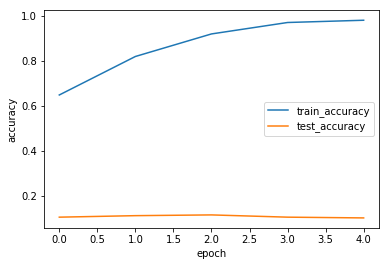

In [0]:
import matplotlib.pyplot as plt
def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

show_history(history)